In [1]:
%load_ext autoreload
%autoreload 2

import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from attention.img_proc.img_process import *
from attention.img_proc.img_split import *
from attention.models.face_models import *
from attention.utils.img_plot import *
from attention.utils.utilities import *
from attention.params import *
import copy

objc[41575]: Class CaptureDelegate is implemented in both /Users/amine/.pyenv/versions/3.10.6/envs/attention-env/lib/python3.10/site-packages/cv2/cv2.abi3.so (0x1671524e8) and /Users/amine/.pyenv/versions/3.10.6/envs/attention-env/lib/python3.10/site-packages/mediapipe/.dylibs/libopencv_videoio.3.4.16.dylib (0x168c00860). One of the two will be used. Which one is undefined.
objc[41575]: Class CVWindow is implemented in both /Users/amine/.pyenv/versions/3.10.6/envs/attention-env/lib/python3.10/site-packages/cv2/cv2.abi3.so (0x167152538) and /Users/amine/.pyenv/versions/3.10.6/envs/attention-env/lib/python3.10/site-packages/mediapipe/.dylibs/libopencv_highgui.3.4.16.dylib (0x138df0a68). One of the two will be used. Which one is undefined.
objc[41575]: Class CVView is implemented in both /Users/amine/.pyenv/versions/3.10.6/envs/attention-env/lib/python3.10/site-packages/cv2/cv2.abi3.so (0x167152560) and /Users/amine/.pyenv/versions/3.10.6/envs/attention-env/lib/python3.10/site-packages/me

In [4]:
# Get attention_data directory
current_directory = os.getcwd()
data_directory = os.path.join(current_directory, os.pardir, "attention_data")

In [6]:
attention_df = pd.read_csv(os.path.join(data_directory, 'attention_output.csv'))
attention_df.head()

,frame,timestamp,face_idx,recognition_prediction,recognition_distance,attentive,left_prediction,left_score,right_prediction,right_score,head_direction_prediction,head_direction_score,head_inclination_prediction,head_inclination_score
0,Midbatch_ds300,300,0,Lancelot,0.48,False,straight,0.44,straight,0.36,head left,0.44,head level,1.26
1,Midbatch_ds300,300,1,NaN,0.76,True,straight,0.50,straight,0.50,head centered,1.12,head level,1.44
2,Midbatch_ds300,300,2,Noah,0.53,True,straight,0.53,straight,0.50,head centered,0.87,head level,1.70
3,Midbatch_ds300,300,3,Julie,0.56,False,straight,0.44,straight,0.52,head centered,0.94,head down,1.77
4,Midbatch_ds300,300,4,Agos,0.45,False,straight,0.22,sideway,0.67,head centered,1.65,head level,1.18


In [7]:
attention_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2833 entries, 0 to 2832
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   frame                        2833 non-null   object 
 1   timestamp                    2833 non-null   int64  
 2   face_idx                     2833 non-null   int64  
 3   recognition_prediction       2207 non-null   object 
 4   recognition_distance         2573 non-null   float64
 5   attentive                    2833 non-null   bool   
 6   left_prediction              2833 non-null   object 
 7   left_score                   2833 non-null   float64
 8   right_prediction             2833 non-null   object 
 9   right_score                  2833 non-null   float64
 10  head_direction_prediction    2833 non-null   object 
 11  head_direction_score         2833 non-null   float64
 12  head_inclination_prediction  2833 non-null   object 
 13  head_inclination_s

In [25]:
attention_df.columns

Index(['frame', 'timestamp', 'face_idx', 'recognition_prediction',
       'recognition_distance', 'attentive', 'left_prediction', 'left_score',
       'right_prediction', 'right_score', 'head_direction_prediction',
       'head_direction_score', 'head_inclination_prediction',
       'head_inclination_score'],
      dtype='object')

<Axes: xlabel='timestamp'>

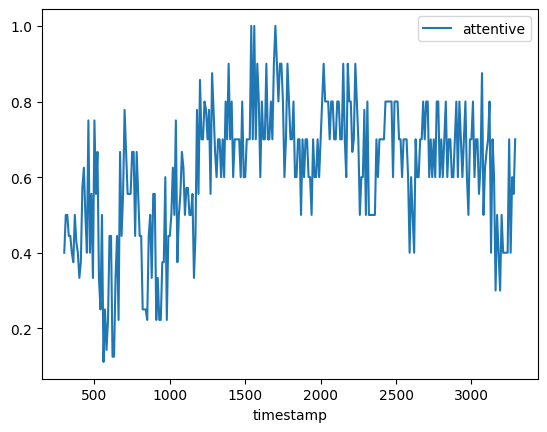

In [24]:
attention_sec = attention_df.groupby('timestamp')[['attentive']].mean()
attention_sec.plot()

<Axes: xlabel='timestamp'>

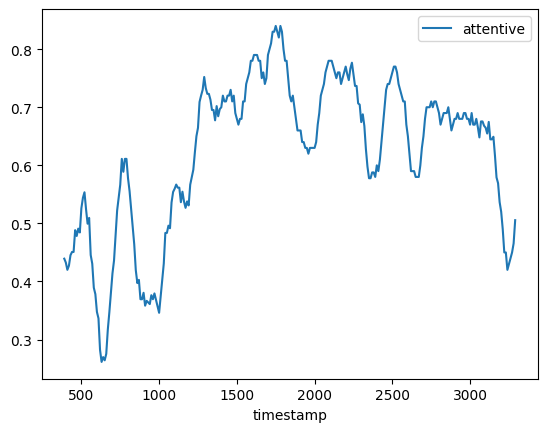

In [23]:
attention_ma = attention_sec.rolling(window=10).mean().dropna()
attention_ma.plot()

<Axes: xlabel='timestamp'>

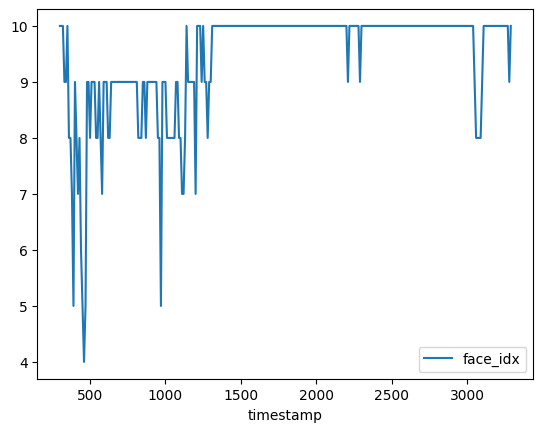

In [21]:
detection_sec = attention_df.groupby('timestamp')[['face_idx']].count()
detection_sec.plot()

In [49]:
recog_perf = attention_df['recognition_prediction'].value_counts(normalize=True,dropna=False).round(2)
recog_perf

NaN         0.22
Noah        0.10
Agos        0.10
Julie       0.10
Isa         0.09
Emi         0.09
Gonzalo     0.08
Sara        0.07
Lancelot    0.07
Juliette    0.07
Leo         0.00
Amine       0.00
Emilia      0.00
Name: recognition_prediction, dtype: float64

In [31]:
recognized_mask = ~attention_df['recognition_prediction'].isna()
recognized_mask

0        True
1       False
2        True
3        True
4        True
        ...  
2828     True
2829     True
2830     True
2831     True
2832     True
Name: recognition_prediction, Length: 2833, dtype: bool

<Axes: xlabel='timestamp'>

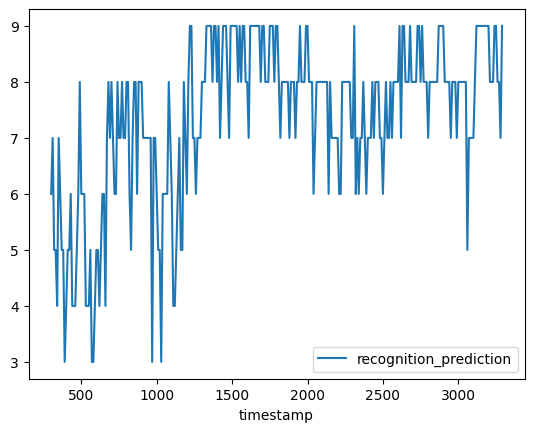

In [37]:
recognition_sec = attention_df[recognized_mask].groupby('timestamp')[['recognition_prediction']].count()
recognition_sec.plot()

<Axes: xlabel='timestamp'>

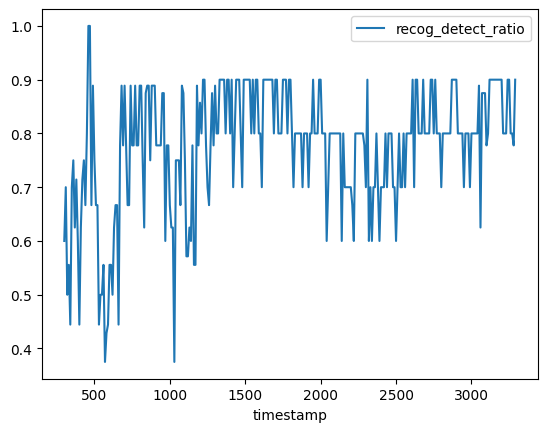

In [47]:
recognized_from_detected_sec = (recognition_sec['recognition_prediction'] / detection_sec['face_idx']).to_frame('recog_detect_ratio')
recognized_from_detected_sec.plot()